In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [2]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)

In [3]:
# Time based splittin
final = final.sort_values(by=['Time'],ascending=False)
finalDataPoints = final.head(20000)
x = finalDataPoints['CleanedText']
y = finalDataPoints['Score']
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)
x_train,x_cv,y_train,y_cv = train_test_split(x_tr,y_tr,test_size = 0.2,shuffle=False)

# TFIDF-W2V

In [4]:
i = 0
list_of_sent = []
for sent in x_train:
    list_of_sent.append(sent.split())
i = 0
list_of_sent_cv = []
for sent in x_cv:
    list_of_sent_cv.append(sent.split())
i = 0
list_of_sent_test = []
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [5]:
w2v_model = Word2Vec(list_of_sent, min_count = 5,size = 50)

In [6]:
w2v_words = list(w2v_model.wv.vocab)
print('number of words that occured minumum 5 times',len(w2v_words))
print('Sample_words',w2v_words[0:50])

number of words that occured minumum 5 times 4581
Sample_words ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'great', 'product', 'good', 'price', 'definit', 'order', 'use', 'bottl', 'empti', 'expect', 'box', 'full', 'fortun', 'cooki', 'like', 'one', 'nonetheless', 'got', 'small', 'tast', 'weird', 'okay', 'best', 'ever', 'review', 'amazon', 'check', 'label', 'contain', 'sure', 'enough', 'top', 'done', 'research', 'also', 'found', 'toxic']


In [7]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train)
final_tf_idf_test = tf_idf_vect.transform(x_test)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))

In [8]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors =[]
row = 0
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum +=tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    
    tfidf_sent_vectors.append(sent_vec)
    row += 1
        

100%|███████████████████████████████████████████████████████████████████████████| 12800/12800 [00:18<00:00, 685.33it/s]


In [9]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []
row = 0
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50)
    weight_sum = 0
    
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 542.28it/s]


In [10]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_cv = []
row = 0
for sent in tqdm(list_of_sent_cv):
    sent_vec = np.zeros(50)
    weight_sum = 0
    
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row+=1

100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:04<00:00, 641.20it/s]


In [11]:
x_test = tfidf_sent_vectors_test
x_cv = tfidf_sent_vectors_cv
x_train = tfidf_sent_vectors
scores = []
myList = list(range(0,30))
neighbors = list(filter(lambda x: x%2 != 0,myList))
scores = []
for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(x_train,y_train)
    pred = knn.predict(tfidf_sent_vectors_cv)
    score = f1_score(y_cv,pred,average='micro')
    scores.append(score)
optimal_k_using_kdtree = neighbors[scores.index(max(scores))]
print(optimal_k_using_kdtree)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.03s/it]

15


Accuracy on test set: 83.150%
Precision on test set: 0.713
Recall on test set: 0.561
F1-Score on test set: 0.569


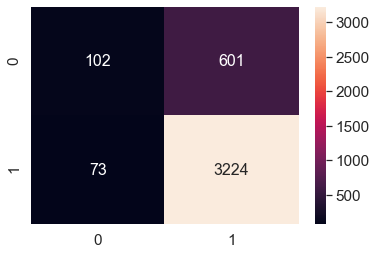

In [12]:
knn = KNeighborsClassifier(n_neighbors=optimal_k_using_kdtree,algorithm='kd_tree')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Naive bayes on Amazon fine food reviews using BOW

In [13]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)

In [14]:
# Time based splitting
final = final.sort_values(by=['Time'],ascending=False)
finalDataPoints = final.head(20000)
x = finalDataPoints['CleanedText']
y = finalDataPoints['Score']
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)
x_train,x_cv,y_train,y_cv = train_test_split(x_tr,y_tr,test_size = 0.2,shuffle=False)

In [15]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_train)
x_test_uni = bow.transform(x_test)


# Finding the optimal Alpha using GridSearch

In [16]:
NB = MultinomialNB()
alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_uni,y_train)
print('Best HyperParameter: ',gsv.best_params_)
print(gsv.best_score_)
optimal_alpha = gsv.best_params_['alpha']


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'alpha': 0.5}
0.8864062500000001


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    8.9s finished


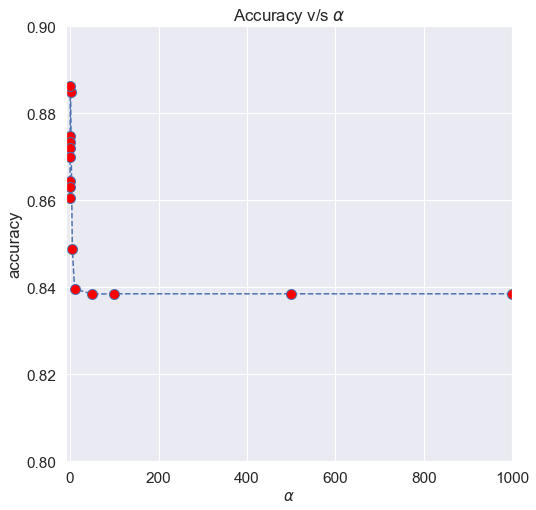

In [17]:
x=[]
y = [] 
for i in range(0,len(alpha_value['alpha'])): 
    x.append(gsv.cv_results_['params'][i]['alpha'])
    y.append(gsv.cv_results_["mean_test_score"][i])
plt.figure(figsize=(8,8))
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

Accuracy on test set: 88.350%
Precision on test set: 0.811
Recall on test set: 0.759
F1-Score on test set: 0.781


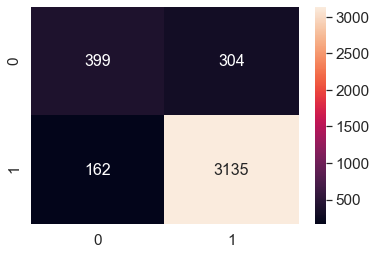

In [20]:
NB = MultinomialNB(optimal_alpha)
NB.fit(x_tr_uni,y_train)
y_pred = NB.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [35]:
# Feature importence
neg_class_prob_sorted = (-NB.feature_log_prob_[0,:]).argsort()
pos_class_prob_sorted = (-NB.feature_log_prob_[1,:]).argsort()
print('important negative features are::\n')
print(np.take(bow.get_feature_names(),neg_class_prob_sorted[:10]))
print('important positive features are::\n')
print(np.take(bow.get_feature_names(),pos_class_prob_sorted[:10]))


important negative features are::

['tast' 'like' 'product' 'would' 'one' 'flavor' 'tri' 'use' 'order'
 'coffe']
important positive features are::

['like' 'tast' 'love' 'good' 'use' 'flavor' 'great' 'product' 'one'
 'coffe']


# naive_bayes with tfidf

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   12.2s finished


Best HyperParameter:  {'alpha': 0.1}
0.870703125


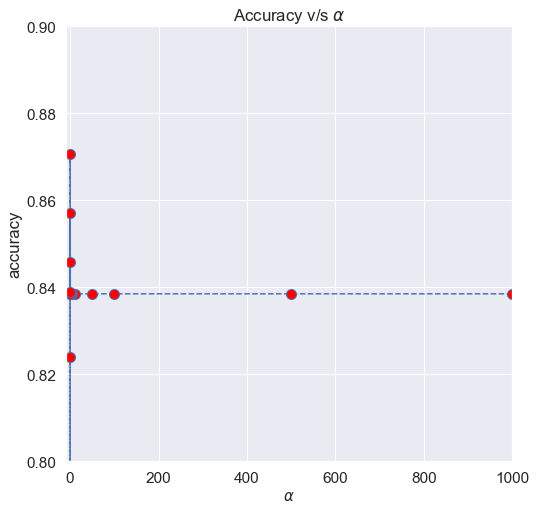

In [40]:
NB = MultinomialNB()
alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_tfidf,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']


x=[]
y=[]
plt.figure(figsize=(8,8))
for i in range(0,len(alpha_value['alpha'])): 
    x.append(gsv.cv_results_['params'][i]['alpha'])
    y.append(gsv.cv_results_["mean_test_score"][i])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()


In [ ]:

NB = MultinomialNB(optimal_alpha)
NB.fit(x_tr_tfidf,y_tr)
y_pred = NB.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')